$x[n]$, $y[n]$ are the observed signal, $h[n]$ is an unknown system. By $x[n]$, $y[n]$ we can derivive $h[n]$ in below's equation:

$$
y[i] = x[n]^\top \cdot h[n]
$$

$$
d[i] = y[i] + v[i]
$$

But if the system contains interference $v[i]$, what we can observed is $d[i]$ and $x[i]$, $y[i]$ now become a estimated value and $h_{opt}[i]$ which is an optimal value:
$$
\hat{y[i]} = x[i]^\top \cdot h_{opt}[i]
$$

Difference between esitmated and current value:
$$
e[i] = y[i] - \hat{y[i]}
$$

Get the square of the error: 
$$
\begin{align}
e[i]^2 = e[i]^\top e[i] &= (y[i] - \hat{y[i]})^\top (y[i] - \hat{y[i]})
\\&= (y[i] - x[i]^\top \cdot h_{opt}[i])^\top (y[i] - x[i]^\top \cdot h_{opt}[i])
\\&= (y[i]^\top - h_{opt}[i]^\top \cdot x[i]) (y[i] - x[i]^\top \cdot h_{opt}[i])
\\&= (y[i] - h_{opt}[i]^\top \cdot x[i]) (y[i] - x[i]^\top \cdot h_{opt}[i])
\\&= (y[i]^2 - y[i] x[i]^\top h_{opt}[i] - y[i] h_{opt}[i]^\top x[i] + h_{opt}[i]^\top x[i] x[i]^\top h_{opt}[i])
\\&= (y[i]^2 - 2y[i] x[i]^\top h_{opt}[i] + h_{opt}[i]^\top x[i] x[i]^\top h_{opt}[i])
\end{align}
$$


take quadratic function as example(parabola):
$$
f(x) = ax^2 + bx + c
\begin{cases}
 a > 0: convex function \\
 a < 0: concave function
\end{cases}
$$

combie above idea with error square:
$$
f(h_{opt}[i]) = (y[i]^2 - 2y[i] x[i]^\top h_{opt}[i] + h_{opt}[i]^\top x[i] x[i]^\top h_{opt}[i])
$$

$$
\begin{align}
slope = \frac{\partial e[i]^2 }{\partial h_{opt}[i]} &= (- 2y[i] x[i] + 2 x[i] x[i]^\top h_{opt}[i]) \\
&= -2 x[i] (y[i] - x[i]^\top h_{opt}[i])
\end{align}
$$

we add a 1/2 before multiply slope, in order to cancel out the ratio in slope:
$$
\begin{align}
h_{opt}[i+1] &= h_{opt}[i] - \frac{1}{2} \cdot u \cdot slope \\
&= h_{opt}[i] - \frac{1}{2} \cdot u \cdot (-2 x[i] (y[i] - x[i]^\top h_{opt}[i])) \\
&= h_{opt}[i] + u \cdot x[i] \cdot (y[i] - x[i]^\top h_{opt}[i]) \\
&= h_{opt}[i] + u \cdot x[i] \cdot (y[i] - \hat{y[i]}) \\
&= h_{opt}[i] + u \cdot x[i] \cdot e[i]
\end{align}
$$

now we can get the concolusion:
$$
h_{opt}[i+1] = h_{opt}[i] + u \cdot x[i] \cdot e[i]
$$


In [1]:
import numpy as np
import collections
import scipy.signal
import matplotlib.pyplot as plt
import wavio
import IPython

In [2]:
def lms(un, dn, M, mu):
    """
    :param un: unknow signal
    :type  un: numpy.ndarray
    :param dn: expectation signal
    :type  dn: numpy.ndarray
    :param M : length of FIR filter
    :type  M : int
    :param mu: learning rate
    :type  mu: float
    :return: yn, en
    """
    # To ensure the length of un and dn is same
    ITER = min(len(un),len(dn)) 
    
    # Signal buffer
    u = np.zeros(M)
    
    # FIR Weights
    w = np.zeros(M)
    
    # Estimated Signal, FIR Product
    yn = np.zeros(ITER) 
    
    # Error Signal, difference between estimation and expectation
    en = np.zeros(ITER) 
    
    for n in range(ITER):
        u[1:M] = u[0:M-1]
        u[0] = un[n]
        yn[n] = np.dot(w.T, u)
        en[n] = dn[n] - yn[n]
        w = w + mu * en[n] * u
    return yn, en

In [3]:
def nlms(un, dn, M, mu):
    """
    :param un: unknow signal
    :type  un: numpy.ndarray
    :param dn: expectation signal
    :type  dn: numpy.ndarray
    :param M : length of FIR filter
    :type  M : int
    :param mu: learning rate
    :type  mu: float
    :return: yn, en
    """
    # To ensure the length of un and dn is same
    ITER = min(len(un),len(dn)) 
    
    # Signal buffer
    u = np.zeros(M)
    
    # FIR Weights
    w = np.zeros(M) 
    
    # Estimated Signal, FIR Product
    yn = np.zeros(ITER) 
    
    # Error Signal, difference between estimation and expectation
    en = np.zeros(ITER) 
    
    for n in range(ITER):
        u[1:M] = u[0:M-1]
        u[0] = un[n]
        yn[n] = np.dot(w.T, u)
        en[n] = dn[n] - yn[n]
        w = w + mu * en[n] * u / (np.dot(u, u) + 1e-7)
    return yn, en

In [4]:
def leaky_lms(un, dn, M, mu, leaky):
    ITER = min(len(un),len(dn)) 
    u = np.zeros(M)
    w = np.zeros(M) 
    yn = np.zeros(ITER) 
    en = np.zeros(ITER) 
    
    for n in range(ITER):
        u[1:M] = u[0:M-1]
        u[0] = un[n]
        yn[n] = np.dot(w.T, u)
        en[n] = dn[n] - yn[n]
        w = (1 - mu * leaky) * w + mu * en[n] * u
    return yn, en

In [5]:
def modified_leaky_lms(un, dn, M, mu, leaky):
    ITER = min(len(un),len(dn)) 
    u = np.zeros(M)
    w = np.zeros(M) 
    yn = np.zeros(ITER) 
    en = np.zeros(ITER) 
    
    for n in range(ITER):
        u[1:M] = u[0:M-1]
        u[0] = un[n]
        yn[n] = np.dot(w.T, u)
        en[n] = dn[n] - yn[n]
        w = (1 - mu * leaky) * w + mu * en[n] * np.sign(u)
    return yn, en

In [6]:
def wav_processor(input_data):
    output_data = input_data
    for index, data in enumerate(input_data):
        if data > 2:
            output_data[index] = 2
        elif data < -2:
            output_data[index] = -2
    return output_data

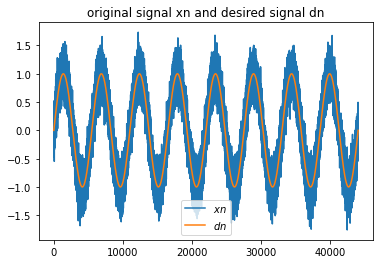

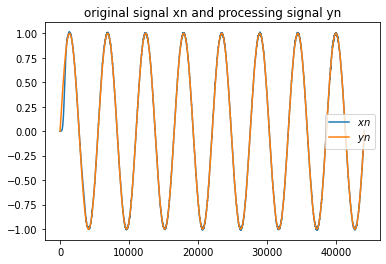

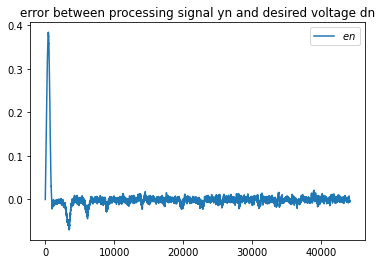

In [7]:
# iteration time
itr = 44100
# FIR taps length
M = 1024
# moving steps, learning rate
mu = 0.00005

noise_size = itr
X = np.linspace(0,4 * np.pi, itr, endpoint=True)
Y = np.sin(X * 4)
signal_array = Y
noise_array = np.random.normal(0, 0.2, noise_size)
signal_noise_array = signal_array + noise_array  

xn = signal_noise_array 
dn = signal_array 

yn, en = lms(xn, dn, M, mu)

plt.figure(1)
plt.plot(xn,label="$xn$")
plt.plot(dn,label="$dn$")
plt.title("original signal xn and desired signal dn")
plt.legend() 

plt.figure(2)
plt.plot(yn,label="$xn$")
plt.plot(dn,label="$yn$")
plt.title("original signal xn and processing signal yn")
plt.legend()
    
plt.figure(3)
plt.plot(en,label="$en$")
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.show()

In [8]:
noise_raw = wavio.read("echo_cancellation/white_noise.wav")
room_raw = wavio.read("echo_cancellation/room_white_noise.wav")

noise = noise_raw.data[:, 0]
noise = noise.astype(np.float32, order='C') / 32767.0

room = room_raw.data[:, 0]
room = room.astype(np.float32, order='C') / 32767.0
delay = 256
room = np.append(np.zeros(delay), room)[:-delay]

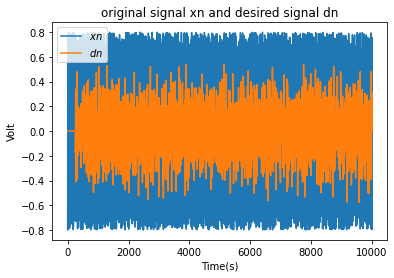

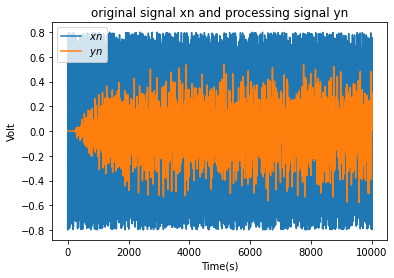

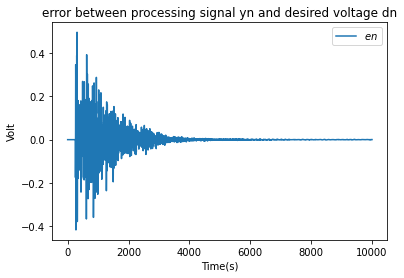

In [9]:
M = 512
mu = 0.005
beat = 88200
leaky = 0.005

xn = noise[:10000]
dn = room[:10000]

(yn,en) = lms(xn, dn, M, mu)

plt.figure(1)
plt.plot(xn,label="$xn$")
plt.plot(dn,label="$dn$")
plt.xlabel("Time(s)")
plt.ylabel("Volt")
plt.title("original signal xn and desired signal dn")
plt.legend() 

plt.figure(2)
plt.plot(xn,label="$xn$")
plt.plot(yn,label="$yn$")
plt.xlabel("Time(s)")
plt.ylabel("Volt")
plt.title("original signal xn and processing signal yn")
plt.legend()
    
plt.figure(3)
plt.plot(en,label="$en$")
plt.xlabel("Time(s)")
plt.ylabel("Volt")
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.show()

In [10]:
news_raw = wavio.read("echo_cancellation/news.wav")
room_news_raw = wavio.read("echo_cancellation/room_news.wav")

news = news_raw.data[:, 0]
news = news.astype(np.float32, order='C') / 32767.0

room = room_news_raw.data[:, 0]
room = room.astype(np.float32, order='C') / 32767.0
delay = 256
room = np.append(np.zeros(delay), room)[:-delay]

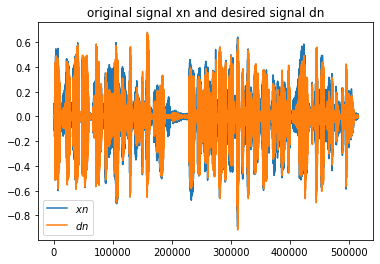

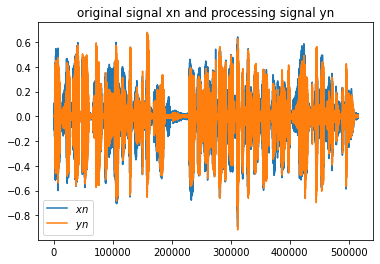

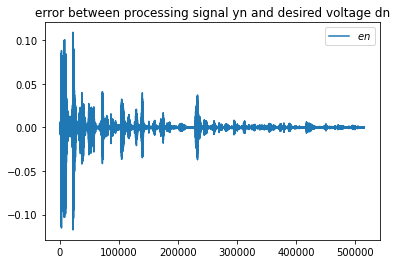

In [11]:
xn = news
dn = room
M = 512
mu = 0.005

(yn,en) = lms(xn, dn, M, mu)

plt.figure(1)
plt.plot(xn,label="$xn$")
plt.plot(dn,label="$dn$")
plt.title("original signal xn and desired signal dn")
plt.legend() 

plt.figure(2)
plt.plot(xn,label="$xn$")
plt.plot(yn,label="$yn$")
plt.title("original signal xn and processing signal yn")
plt.legend()
    
plt.figure(3)
plt.plot(en,label="$en$")
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.show()

In [12]:
female_news_raw = wavio.read("echo_cancellation_conversation/female_news.wav")
room_news_raw = wavio.read("echo_cancellation_conversation/room_female_news.wav")

female_news = female_news_raw.data[:, 0]
female_news = female_news.astype(np.float32, order='C') / 32767.0

room = room_news_raw.data[:, 0]
room = room.astype(np.float32, order='C') / 32767.0
delay = 64
room = np.append(np.zeros(delay), room)[:-delay]

male_news_raw = wavio.read("echo_cancellation_conversation/male_news.wav")
male_news = male_news_raw.data[:, 0]
male_news = male_news.astype(np.float32, order='C') / 32767.0

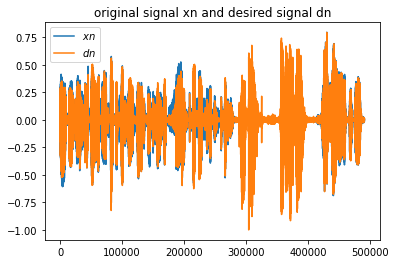

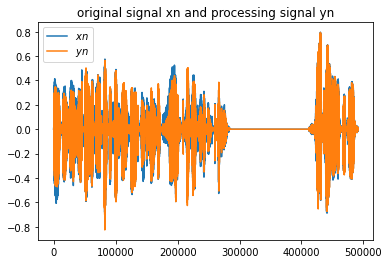

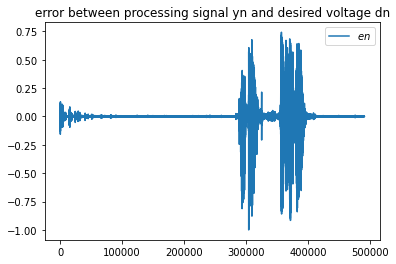

In [13]:
xn = female_news
dn = room + male_news
M = 512
mu = 0.01
leaky = 0.0000005

(yn,en) = leaky_lms(xn, dn, M, mu, leaky)

plt.figure(1)
plt.plot(xn,label="$xn$")
plt.plot(dn,label="$dn$")
plt.title("original signal xn and desired signal dn")
plt.legend() 

plt.figure(2)
plt.plot(xn,label="$xn$")
plt.plot(yn,label="$yn$")
plt.title("original signal xn and processing signal yn")
plt.legend()
    
plt.figure(3)
plt.plot(en,label="$en$")
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.show()

In [14]:
sr = 44100
wavio.write("result/en.wav", en, sr, sampwidth=3)
wavio.write("result/yn.wav", yn, sr, sampwidth=3)
IPython.display.display(IPython.display.Audio("result/en.wav", rate=sr))
IPython.display.display(IPython.display.Audio("result/yn.wav", rate=sr))

In [15]:
music_raw = wavio.read("music/music.wav")
room_drum_raw = wavio.read("music/drum_room.wav")
drum_raw = wavio.read("music/drum.wav")

music = music_raw.data[:, 0]
music = music.astype(np.float32, order='C') / 32767.0

delay = 32

room_drum = room_drum_raw.data[:, 0]
room_drum = room_drum.astype(np.float32, order='C') / 32767.0
# room_drum = np.append(np.zeros(delay), room_drum)[:-delay]

drum = drum_raw.data[:, 0]
drum = drum.astype(np.float32, order='C') / 32767.0
# drum = np.append(np.zeros(delay), drum)[:-delay]

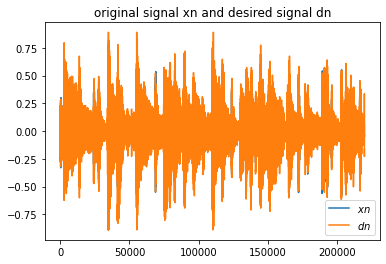

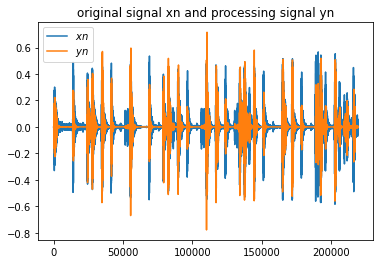

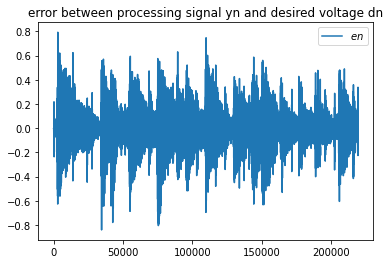

In [16]:
xn = room_drum
dn = music
M = 256
mu = 0.002
leaky = 0.75

(yn,en) = leaky_lms(xn, dn, M, mu, leaky)

plt.figure(1)
plt.plot(xn,label="$xn$")
plt.plot(dn,label="$dn$")
plt.title("original signal xn and desired signal dn")
plt.legend() 

plt.figure(2)
plt.plot(xn,label="$xn$")
plt.plot(yn,label="$yn$")
plt.title("original signal xn and processing signal yn")
plt.legend()
    
plt.figure(3)
plt.plot(en,label="$en$")
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.show()

In [17]:
sr = 16000
wavio.write("result/en_lms.wav", en, sr, sampwidth=3)
wavio.write("result/yn_lms.wav", yn, sr, sampwidth=3)
IPython.display.display(IPython.display.Audio("result/en_lms.wav", rate=sr))
IPython.display.display(IPython.display.Audio("result/yn_lms.wav", rate=sr))
IPython.display.display(IPython.display.Audio("music/music.wav", rate=sr))

In [18]:
def adagrad_lms(un, dn, M, mu):
    """
    :param un: unknow signal
    :type  un: numpy.ndarray
    :param dn: expectation signal
    :type  dn: numpy.ndarray
    :param M : length of FIR filter
    :type  M : int
    :param mu: learning rate
    :type  mu: float
    :return: yn, en
    """
    # To ensure the length of un and dn is same
    ITER = min(len(un),len(dn)) 
    
    # Signal buffer
    u = np.zeros(M)
    
    # FIR Weights
    w = np.zeros(M)
    
    # Estimated Signal, FIR Product
    yn = np.zeros(ITER) 
    
    # Error Signal, difference between estimation and expectation
    en = np.zeros(ITER) 
    
    eta = collections.deque(maxlen=128)
    minima_float = 2.2250738585072014e-308
    
    for n in range(ITER):
        u[1:M] = u[0:M-1]
        u[0] = un[n]
        yn[n] = np.dot(w.T, u)
        en[n] = dn[n] - yn[n]
        
        g_t = u * en[n]
        eta.appendleft(g_t)
        current_size = len(eta)
        eta_array = np.array(eta)
        eta_t = np.sqrt(np.sum(eta_array * eta_array) / current_size)
        w = w + mu * g_t / (eta_t + minima_float)
    return yn, en

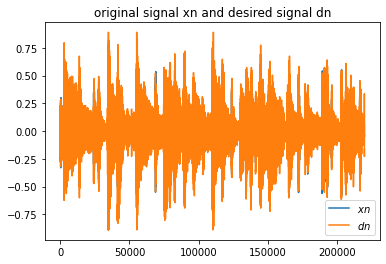

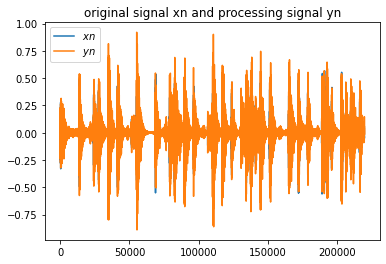

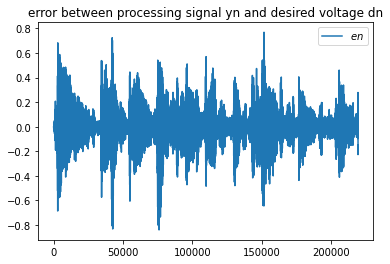

In [19]:
xn = room_drum
dn = music
M = 1024
mu = 0.005

(yn,en) = adagrad_lms(xn, dn, M, mu)

plt.figure(1)
plt.plot(xn,label="$xn$")
plt.plot(dn,label="$dn$")
plt.title("original signal xn and desired signal dn")
plt.legend() 

plt.figure(2)
plt.plot(xn,label="$xn$")
plt.plot(yn,label="$yn$")
plt.title("original signal xn and processing signal yn")
plt.legend()
    
plt.figure(3)
plt.plot(en,label="$en$")
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.show()

In [20]:
sr = 16000
wavio.write("result/en_ada_lms.wav", en, sr, sampwidth=3)
wavio.write("result/yn_ada_lms.wav", yn, sr, sampwidth=3)
IPython.display.display(IPython.display.Audio("result/en_ada_lms.wav", rate=sr))
IPython.display.display(IPython.display.Audio("result/yn_ada_lms.wav", rate=sr))
IPython.display.display(IPython.display.Audio("music/music.wav", rate=sr))